<a href="https://colab.research.google.com/github/mathewsrc/Topic-Modeling-Reclame-Aqui/blob/master/Topic_Modeling_Reclame_Aqui_With_LSI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Connect to GitHub (Only in case you want to push code to GitHub)**

Generate a new ssh key to connect to GitHub

In [ ]:
! ssh-keygen -t rsa -b 4096
# Add github.com to our known hosts
! ssh-keyscan -t rsa github.com >> ~/.ssh/known_hosts
# Restrict the key permissions, or else SSH will complain.
! chmod go-rwx /root/.ssh/id_rsa

In [ ]:
# Print ssh key
! cat /root/.ssh/id_rsa.pub

In [ ]:
# Set email and name
!git config --global user.email ""
!git config --global user.name ""

In [ ]:
!ssh -T git@github.com

## Clone project from GitHub

In [6]:
!git clone git@github.com:punkmic/Topic-Modeling-Reclame-Aqui.git

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Cloning into 'Topic-Modeling-Reclame-Aqui'...
remote: Enumerating objects: 19512, done.
remote: Counting objects: 100% (407/407), done.
remote: Compressing objects: 100% (349/349), done.
remote: Total 19512 (delta 197), reused 225 (delta 56), pack-reused 19105
Receiving objects: 100% (19512/19512), 277.65 MiB | 13.90 MiB/s, done.
Resolving deltas: 100% (3573/3573), done.
Updating files: 100% (1149/1149), done.


## Install packages

In [91]:
%%capture
import pandas as pd
import os
from sklearn.cluster import KMeans
import matplotlib.ticker as ticker
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import pickle
import numpy as np
import itertools
from matplotlib.lines import Line2D
import seaborn as sns
import csv
import ast # for convert str to tuple
try:
  from wordcloud import WordCloud
  import optuna
  import pyLDAvis
  import pyLDAvis.gensim_models as gs
  from gensim.utils import simple_tokenize
  from gensim.models import LsiModel
  from gensim.utils import simple_preprocess
  from gensim import models
  from gensim.corpora import Dictionary
  from gensim.models.coherencemodel import CoherenceModel
  from gensim.models.phrases import Phrases, Phraser
except:
  !pip install gensim
  !pip install pyldavis
  !pip install optuna
  !pip install wordcloud
  from gensim import models
  from gensim.corpora import Dictionary
  from gensim.models.coherencemodel import CoherenceModel
  from gensim.models import LsiModel
  import pyLDAvis.gensim_models as gs
  from gensim.utils import simple_preprocess
  from gensim.models.phrases import Phrases, Phraser
  import optuna

# import custom module
%cd /content/Topic-Modeling-Reclame-Aqui/utils
from max_limit import max_limit
%cd ../

In [92]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

## Load data

In [93]:
WORK_DIR = '/content/Topic-Modeling-Reclame-Aqui'
DATASETS_DIR = '/content/Topic-Modeling-Reclame-Aqui/datasets'

In [94]:
df = pd.read_csv(os.path.join(DATASETS_DIR, 'processed_v1.csv'))

In [95]:
df.head(3)

,title,documents,documents_nouns,bigrams,noun_bigrams,trigrams,noun_trigrams,freq_words_removed,freq_words_removed_nouns
0,pedir cancelado justificativa semana compro,pesquisando bastante novo comprar resolver agu...,semana desconto promoção desconto compra custo...,"[('pesquisando', 'bastante'), ('bastante', 'no...","[('semana', 'desconto'), ('desconto', 'promoçã...","[('pesquisando', 'bastante', 'novo'), ('bastan...","[('semana', 'desconto', 'promoção'), ('descont...",pesquisando bastante novo resolver aguardar se...,semana desconto promoção desconto plataforma c...
1,pedir cancelar,sinceramente decepcionar entrar contato procon...,procon audiência conciliação solicitação produ...,"[('sinceramente', 'decepcionar'), ('decepciona...","[('procon', 'audiência'), ('audiência', 'conci...","[('sinceramente', 'decepcionar', 'entrar'), ('...","[('procon', 'audiência', 'conciliação'), ('aud...",sinceramente decepcionar procon hoje informar ...,procon audiência conciliação solicitação estoq...
2,cobrança indever,cancelei plano antes terminar período testir g...,cancelei período plataforma fatura gratuito ca...,"[('cancelei', 'plano'), ('plano', 'antes'), ('...","[('cancelei', 'período'), ('período', 'platafo...","[('cancelei', 'plano', 'antes'), ('plano', 'an...","[('cancelei', 'período', 'plataforma'), ('perí...",cancelei plano antes terminar período testir g...,cancelei período plataforma fatura gratuito ca...


## Get documents

In [96]:
# Define column name to retrieve data from
COLNAME = 'freq_words_removed_nouns'

# Remove any na value
df.dropna(subset=[COLNAME], inplace=True)

# Get column by name
documents = df[COLNAME]

# Print the number of documents and the first item
print(len(documents))
print(documents[:1])

10292
0    semana desconto promoção desconto plataforma c...
Name: freq_words_removed_nouns, dtype: object


## Define the the results directory

In [97]:
# Define the path to save results
LSI_RESULTS_DIR = os.path.join('/content/Topic-Modeling-Reclame-Aqui/lsi/', COLNAME)

# Create Directory if it not exists
if not os.path.exists(LSI_RESULTS_DIR):
  os.makedirs(LSI_RESULTS_DIR)

Define the number of topics to generate by LSI

In [98]:
NUMBER_OF_TOPICS = 26

Define a function to compute the coherence scores

In [99]:
def compute_model_coeherence_score(ngrams):
    """
    Compute the coherence value of model
    """
    # Tokenize documents
    texts = [
        [word for word in document.lower().split()]
        for document in documents
    ]

    if ngrams == 2 or ngrams == 3:
        # create bigrams
        bigram = Phrases(texts, min_count=1)
        bigram_phraser = Phraser(bigram)
        texts = [bigram_phraser[doc] for doc in texts]

    if ngrams == 3:
      # Create trigrams
      trigram = Phrases(texts, min_count=1)
      trigram_phraser = Phraser(trigram)
      texts = [trigram_phraser[bigram_phraser[token]] for token in texts]


    # Create a dictionary from the tokens
    dictionary = Dictionary(texts)

    # Create a corpus from the tokens
    corpus = [dictionary.doc2bow(text) for text in texts]

    # Create a dict to store the coherence scores
    coherence_scores = {}

    for t in range(2, NUMBER_OF_TOPICS):
        lsi_model = LsiModel(corpus, id2word=dictionary, num_topics=t, random_seed=42)

        cm = CoherenceModel(model=lsi_model, texts=texts, coherence='c_v')
        score = cm.get_coherence()
        tup = t, score
        coherence_scores[t] = score

    return coherence_scores

In [100]:
def get_prefix(ngrams):
  if ngrams == 1:
    prefix = "unigrams"
  elif ngrams == 2:
    prefix = "bigrams"
  elif ngrams == 3:
    prefix = "trigrams"
  else:
     raise Exception("Please add a value between 1 to 3")
  return prefix

Define the function to plot the coherence scores

In [101]:
def plot_coherence(ngrams=1, n_topics=10):

  """
  Plot the coherence score by number of topics
  """

  prefix = get_prefix(ngrams)

  coherence_scores = compute_model_coeherence_score(ngrams)

  # create the plot
  plt.figure(figsize=[10, 8])

  # create a line plot
  ax = sns.lineplot(x=list(coherence_scores.keys()), y=list(coherence_scores.values()), color='#238C8C')

  # add labels to the axes
  plt.xlabel('Número de Tópicos')
  plt.ylabel('Coerência (score)')
  plt.title("Coerência por número de tópicos", fontsize=16)

  # set x-axis limits
  plt.xlim(2, n_topics)

  # customize x-ticks
  plt.xticks(range(2, n_topics, 2))

  # Add a vertical line to show the optimum number of topics
  position = list(coherence_scores.keys())[np.argmax(list(coherence_scores.values()))]
  plt.axvline(position,  color='#F26457', linestyle='--')

  # Draw a custom legend
  legend_elements = [Line2D([0], [0], color='#238C8C',
                          ls='-', label='Valor de coerência (c_v)'),
                   Line2D([0], [1], color='#F26457',
                          ls='--', label='Número de tópicos ótimo')]

  ax.legend(handles=legend_elements, loc='upper right')

  # save plot
  plt.savefig(os.path.join(LSI_RESULTS_DIR, f'{prefix}_coherence_by_topics.png'))

  # show the plot
  plt.show()

### **Unigram**

Plot coherence by number of topics

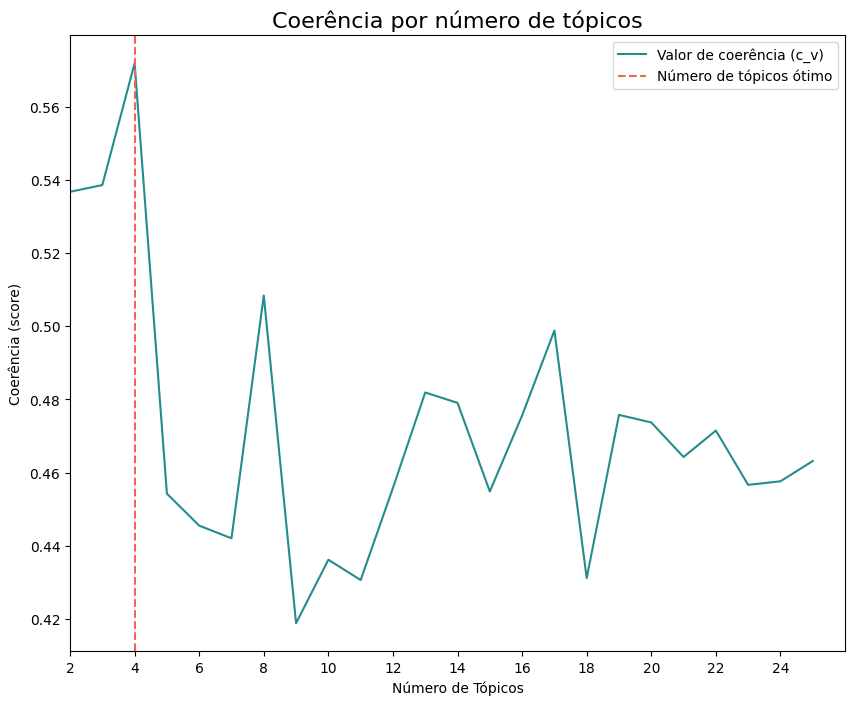

In [102]:
plot_coherence(ngrams=1, n_topics=NUMBER_OF_TOPICS)

#### **Unigram + Bigram**

Plot coherence by number of topics

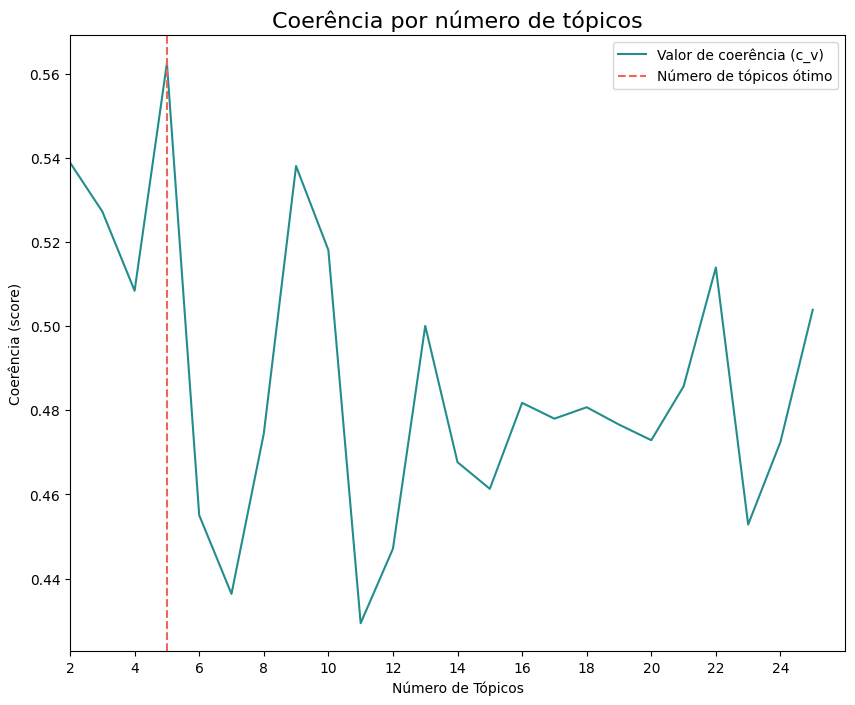

In [103]:
plot_coherence(ngrams=2, n_topics=NUMBER_OF_TOPICS)

#### **Unigram + Bigram + Trigram**

Plot coherence by number of topics when using three forms of ngram together

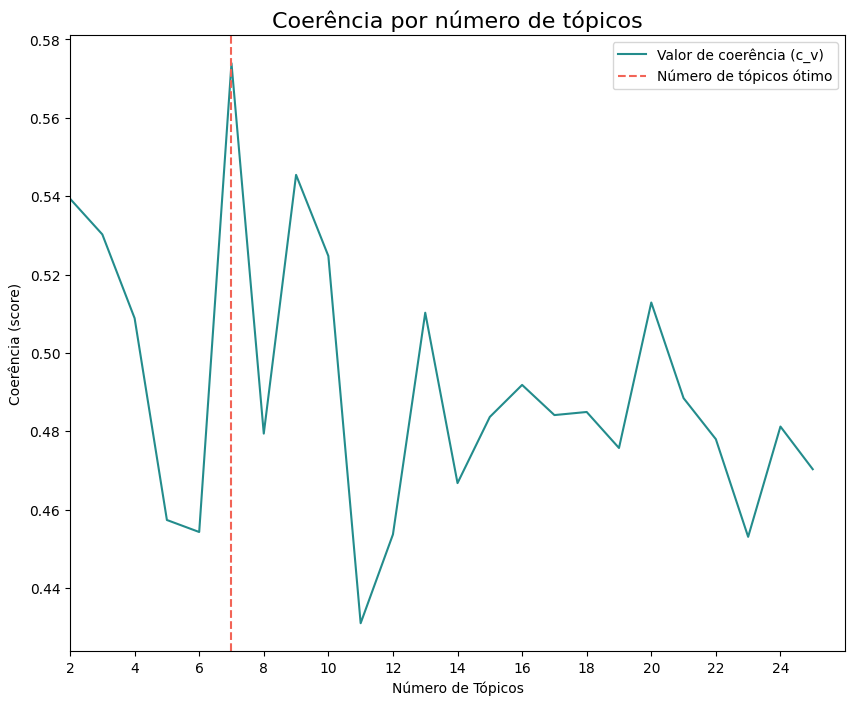

In [104]:
plot_coherence(ngrams=3, n_topics=NUMBER_OF_TOPICS)

In [105]:
def get_topics(lsi, nr_topics):
  """
  Extract topics and words from model and return a pandas DataFrame
  """
  x=lsi.show_topics(num_topics=nr_topics, num_words=10, formatted=False)
  topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]
  topics = []
  words = []
  for t, w in topics_words:
    topics.append(t)
    words.append(w)
  return pd.DataFrame({'Tópicos': topics, 'Words': words})

## Use Optuna to ramdonly select different Hyperparameters value

In [108]:
# Set the minimum and maximum number of topics
MIN_TOPICS = 4
MAX_TOPICS = 30


def optimizer(trial):
  """
  Randomly select the value of Hyperparameters, train the model, save
  the results and return the coherence score
  """

  ngram_range = ast.literal_eval(trial.suggest_categorical('ngram_range', ['(1,1)', '(1,2)', '(1,3)']))
  nr_topics = trial.suggest_int('lsi__nr_topics', MIN_TOPICS, MAX_TOPICS)
  min_count = trial.suggest_int('bigram__min_count', 2, 20)
  filter = trial.suggest_float('dictionary__filter_extremes', 0.70, 0.95)

  # Tokenize documents into words
  texts = [
      [word for word in document.lower().split()]
      for document in documents
  ]

  if ngram_range == (1,2):
    # Create bigrams
    bigram = Phrases(texts, min_count=min_count)
    bigram_phraser = Phraser(bigram)
    texts = [bigram_phraser[token] for token in texts]
  elif ngram_range == (1,3):
    # Create bigrams
    bigram = Phrases(texts, min_count=min_count)
    bigram_phraser = Phraser(bigram)
    texts = [bigram_phraser[token] for token in texts]

    # Create trigrams
    trigram = Phrases(texts, min_count=min_count)
    trigram_phraser = Phraser(trigram)
    texts = [trigram_phraser[bigram_phraser[token]] for token in texts]


  # create a corpus from a list of texts
  dictionary = Dictionary(texts)

  # Filter out words that occur more than X% of the documents.
  dictionary.filter_extremes(no_above=filter)

  # convert documents to bag of words
  corpus = [dictionary.doc2bow(text) for text in texts]

  # create a new LSI model
  lsi_model = LsiModel(corpus=corpus,
                           id2word=dictionary,
                           num_topics=nr_topics,
                           random_seed=100)

  # compute coherence score
  score = CoherenceModel(lsi_model, texts=texts, corpus=corpus, dictionary=dictionary).get_coherence()

  new_file = False

  # write header if document does not exists
  if not os.path.exists(os.path.join(LSI_RESULTS_DIR, f'coherence_scores.csv')):
       new_file = True

   # save scores
  if not os.path.exists(LSI_RESULTS_DIR):
     os.makedirs(LSI_RESULTS_DIR)

  # Append data to CSV file
  with open(path, 'a', newline='') as f:

     # Define the CSV column names
     fieldnames = ['topic', 'ngram_range', 'min_count', 'filter', 'score']

     # Create a new DictWriter instance
     writer = csv.DictWriter(f, fieldnames=fieldnames)

     # Define the header and values to save into CSV
     data = [{'topic': nr_topics,
              'ngram_range': ngram_range,
              'min_count': min_count,
              'filter':filter,
              'score': score}]

     # Write header if CSV does not exists
     if new_file:
       writer.writeheader()

     # write rows
     writer.writerows(data)

     # Save model topics
     os.makedirs(os.path.join(LSI_RESULTS_DIR, "models_topics"), exist_ok=True)
     df_topics = get_topics(lsi_model, nr_topics)
     df_topics.to_csv(os.path.join(LSI_RESULTS_DIR, "models_topics", f"topics_trial_{trial.number}.csv"))

  return  score

In [109]:
%%time

# delete csv if it exists
path = os.path.join(LSI_RESULTS_DIR, f'coherence_scores.csv')
if os.path.exists(path):
  os.remove(path)

# Define the number of models to generate by Optuna
NUMBER_OF_MODELS = 50

# create a new study
study = optuna.create_study(study_name=f'LSI_{COLNAME}', direction='maximize')

# run the optmize function
study.optimize(optimizer, n_trials=NUMBER_OF_MODELS, show_progress_bar=True)

print(f'Study name: {study.study_name}')
print(f"Best trial: {study.best_trial}")
print(f'Best value: {study.best_value}')
print(f'Best params: {study.best_params}')


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2023-10-25 00:08:21,382] Trial 0 finished with value: 0.5326500550016177 and parameters: {'ngram_range': '(1,3)', 'lsi__nr_topics': 7, 'bigram__min_count': 6, 'dictionary__filter_extremes': 0.7230802155825722}. Best is trial 0 with value: 0.5326500550016177.
[I 2023-10-25 00:08:23,820] Trial 1 finished with value: 0.47141968909507737 and parameters: {'ngram_range': '(1,3)', 'lsi__nr_topics': 8, 'bigram__min_count': 7, 'dictionary__filter_extremes': 0.884365512237548}. Best is trial 0 with value: 0.5326500550016177.
[I 2023-10-25 00:08:26,903] Trial 2 finished with value: 0.492979602446702 and parameters: {'ngram_range': '(1,3)', 'lsi__nr_topics': 22, 'bigram__min_count': 19, 'dictionary__filter_extremes': 0.8647500594018962}. Best is trial 0 with value: 0.5326500550016177.
[I 2023-10-25 00:08:28,782] Trial 3 finished with value: 0.477352838180372 and parameters: {'ngram_range': '(1,1)', 'lsi__nr_topics': 16, 'bigram__min_count': 9, 'dictionary__filter_extremes': 0.8767255672868411}.

### **Remove GitHub connection**

In [90]:
!rm -rf /root/.ssh/